## Bayesian Networks - Cardiovascular Disease Dataset

**Group Number:** 14  
**Student Names:** Andrea Fruttidoro (66373); Pedro Fanica (54346); Quentin WEISS (66292);

---
---

In [56]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Machine_Learning_ADV/Project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


>>[Bayesian Networks - Cardiovascular Disease Dataset](#scrollTo=cjK7vkRjLwFM)

>>[0. Useful Tools](#scrollTo=em9I07bR-78-)

>>[1. Introduction](#scrollTo=QHj9fz5OA49p)

>>[2. Preprocessing and Discretization](#scrollTo=hjceLH_ZA5q9)

>>[3. Parameter Learning](#scrollTo=DDHqdUfhCXve)

>>>[3.1 Train-test splitting](#scrollTo=eVKN4ZrRDAbr)

>>>[3.2 First Bayesian Network fit and parameter estimation](#scrollTo=ywEWMljQDHNd)

>>>[3.3 Grid search for ESS](#scrollTo=JSH9PZckR2lj)

>>>[3.4 Bayesian Parameter estimation](#scrollTo=Bc7UJ3LoWcEl)

>>>[3.5 Comparison Between CPTs Estimated via Relative Frequencies (M2) and Bayesian Estimation (BDeu, ESS=100)](#scrollTo=BDHmLH-0YI3u)

>>>>[3.5.1. Distance and Divergence Metrics for Probability Distributions](#scrollTo=DyIU6JMv2bNH)

>>>>[3.5.2. Interpretation of CPD Comparison Results](#scrollTo=NQiOgn5erQBQ)

>>[4. Structure Learning](#scrollTo=sK3phWJHuTjr)

>>>[4.1. Robust Structure Learning Framework](#scrollTo=0cusUokGirEu)

>>>[4.2. Expert-Guided Constraint Specification](#scrollTo=ajXsSYLHRrzo)

>>>[4.3. Structure Learning Results](#scrollTo=0rKcmYjTcHW0)

>>[5.  Comparison between learned and human-designed (our) BN model](#scrollTo=4F3sHeaBTs5S)

>>>[5.1. Interpretation and Discussion of Bayesian Network Scores](#scrollTo=x9KSRUPUkep5)

>>[6.  Cross-Validation Methods for Robust Evaluation](#scrollTo=mS1VWsSTkimi)

>>[7.  Overall Project Conclusion](#scrollTo=M_Lw1b8Ukm39)



## 0.&nbsp;Useful Tools

In [57]:
!pip install pgmpy
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import random
from itertools import product
from IPython.display import display, Image
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import (
    MaximumLikelihoodEstimator,BayesianEstimator,
    ExpectationMaximization,ExhaustiveSearch,
    HillClimbSearch, K2, BDeu, BDs, BIC, AIC, ExpertKnowledge
)
from pgmpy.base import DAG
import logging
logging.getLogger("pgmpy").setLevel(logging.ERROR)

In [109]:
# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

# -------- Used in previous milestones --------
def summarize_missing(df):
    """
    Summarize missing values in the dataset.

    Returns
    -------
    summary : pd.DataFrame or None
        DataFrame with column, dtype, count of missing values,
        % missing, and column type classification.
        Returns None if no missing values.
    """
    total_rows = len(df)
    missing_info = (
        df.isnull()
        .sum()
        .reset_index()
        .rename(columns={"index": "column", 0: "missing_count"})
    )
    missing_info["missing_pct"] = (missing_info["missing_count"] / total_rows) * 100

    # Filter only columns with missing values
    summary = missing_info[missing_info["missing_count"] > 0].reset_index(drop=True)

    if summary.empty:
        print("✅ No missing values detected.")
        return None
    else:
        print("Missing values detected:")
        return summary

def custom_impute(df, num_cols, cat_cols, col_to_group=None, verbose=False):
    """
    Impute missing values using local context (values before and after each NaN).

    - Numeric: linear interpolation between previous & next values; edges filled with ffill/bfill
    - Categorical: forward-fill then back-fill (last known value)

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    num_cols : list
        List of numeric columns to impute.
    cat_cols : list
        List of categorical columns to impute.
    col_to_group : str or None, optional
        Column name to group by (e.g., patient ID). If None, no grouping is applied.
    verbose : bool, default False
        If True prints counts of filled values per column.

    Returns
    -------
    pd.DataFrame
        DataFrame with imputed values (same index/order as input).
    """
    df = df.copy()

    def impute_group(group):
        g = group.copy()

        # Numeric columns: interpolate then forward/back fill
        for col in num_cols:
            if col in g.columns:
                before_na = g[col].isna().sum()
                if before_na > 0:
                    # try numeric interpolation (works only for numeric dtype)
                    try:
                        g[col] = g[col].interpolate(method='linear', limit_direction='both')
                    except Exception:
                        # fallback: do not crash if non-numeric
                        pass

                    # fill edge NaNs
                    g[col] = g[col].ffill().bfill()

                    if verbose:
                        after_na = g[col].isna().sum()
                        filled = before_na - after_na
                        print(f"[group {g.name if hasattr(g, 'name') else ''}] Filled {filled} NaNs in numeric column '{col}'")

        # Categorical columns: forward-fill then back-fill
        for col in cat_cols:
            if col in g.columns:
                before_na = g[col].isna().sum()
                if before_na > 0:
                    g[col] = g[col].ffill().bfill()
                    if verbose:
                        after_na = g[col].isna().sum()
                        filled = before_na - after_na
                        print(f"[group {g.name if hasattr(g, 'name') else ''}] Filled {filled} NaNs in categorical column '{col}'")

        return g

    # Apply grouped or global imputation
    if col_to_group:
        # Try the pandas>=2.2 concise call first (silences future deprecation)
        try:
            res = df.groupby(col_to_group, group_keys=False, include_groups=False).apply(impute_group)
            # ensure same row order as original
            res = res.loc[df.index]
            return res
        except TypeError:
            # include_groups not supported in this pandas version -> fallback to manual loop (no warning)
            parts = []
            # preserve grouping order by iterating groupby(sort=False)
            for _, grp in df.groupby(col_to_group, sort=False):
                parts.append(impute_group(grp))
            res = pd.concat(parts)
            # reindex to original order (important)
            res = res.loc[df.index]
            return res
    else:
        # No grouping: just operate on full dataframe
        res = impute_group(df)
        return res


def estimate_cpt(df, child, parents, laplace=1):
    child_states = sorted(df[child].dropna().unique().tolist())
    parents_states = [sorted(df[p].dropna().unique().tolist()) for p in parents]
    parent_combos = list(product(*parents_states)) if parents else [()]

    counts = {}
    for combo in parent_combos:
        if parents:
            mask = np.logical_and.reduce([(df[p] == v) for p,v in zip(parents, combo)])
            sub = df[mask]
        else:
            sub = df
        c = sub[child].value_counts().reindex(child_states, fill_value=0).astype(float)
        c = c + laplace  # lissage de Laplace
        probs = (c / c.sum()).values
        counts[combo] = probs

    cpt_matrix = np.column_stack([counts[combo] for combo in parent_combos])
    return child_states, parents_states, cpt_matrix

def print_full(cpd):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    TabularCPD._truncate_strtable = backup

# -------- M4 specific --------

def compute_log_likelihood(model, data, epsilon=1e-12):
    """
    Compute log-likelihood for a Bayesian Network model.

    Args:
        model: BayesianNetwork model
        data: DataFrame to evaluate
        fit_model: Auto-fit if no CPDs (default: False)
        epsilon: Minimum probability to avoid log(0) (default: 1e-12)
        verbose: Print warnings (default: False)

    Returns:
        float: Log-likelihood score, -np.inf on failure

    Note: Prone to overfitting - prefer BIC/AIC for model selection.
    """
    try:
        cpds = model.get_cpds()
        if not cpds: raise ValueError("No CPDs - fit model first")

        # Precompute CPD info
        cpd_info = []
        for cpd in cpds:
            vars_list = cpd.variables
            multipliers = [1]
            if len(vars_list) > 1:
                parent_cards = cpd.cardinality[1:]
                multipliers = [np.prod(parent_cards[i+1:]) for i in range(len(parent_cards))]

            cpd_info.append({
                'child': vars_list[0], 'parents': vars_list[1:],
                'values': cpd.get_values(), 'state_names': cpd.state_names,
                'multipliers': multipliers
            })

        total_ll = 0.0
        for row_idx, row in data.iterrows():
            row_ll = 0.0
            for info in cpd_info:
                try:
                    child_idx = info['state_names'][info['child']].index(row[info['child']])

                    if not info['parents']:
                        prob = info['values'][child_idx, 0]
                    else:
                        parent_idxs = [info['state_names'][p].index(row[p]) for p in info['parents']]
                        col_idx = sum(idx * mult for idx, mult in zip(parent_idxs, info['multipliers']))
                        prob = info['values'][child_idx, col_idx]

                    row_ll += np.log(max(prob, epsilon))
                except (ValueError, IndexError):
                    print(f"Missing state row {row_idx}, var {info['child']}")
                    row_ll += np.log(epsilon)

            total_ll += row_ll

        return total_ll

    except Exception as e:
        print(f"Failed: {e}")
        return -np.inf

def compare_cpds(bayes_cpds, freq_cpds):
    for bcpd in bayes_cpds:
        node = bcpd.variable
        fcpd = next(c for c in freq_cpds if c.variable == node)

        print(f"\n=== Node: {node} ===")
        print("Bayesian CPT (smoothed):")
        print_full(bcpd)
        print("Frequency CPT (M2):")
        print_full(fcpd)
        print("----------")

def kl_divergence(p, q):
    """Kullback-Leibler Divergence: D_KL(p || q)."""
    # Use scipy.stats.entropy(pk, qk)
    # Note: Requires p and q to be valid probability distributions (sum to 1)
    return entropy(p, qk=q)

def jensen_shannon_distance(p, q):
    """Jensen-Shannon Distance."""
    # Already imported from scipy.spatial.distance
    # Note: Returns the square root of the JS divergence (a true distance metric).
    return jensenshannon(p, q)

def hellinger_distance(p, q):
    """Hellinger Distance."""
    # No dedicated standard library function, use direct numpy calculation
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q)) ** 2))

def l1_distance(p, q):
    """L1 Distance (Manhattan Distance)."""
    # Use numpy.linalg.norm with order 1
    return np.linalg.norm(p - q, ord=1)

def l2_distance(p, q):
    """L2 Distance (Euclidean Distance)."""
    # Use numpy.linalg.norm with order 2 (default)
    return np.linalg.norm(p - q, ord=2)

def generate_random_seeds(n_seeds=10, base_seed=42, method='systematic'):
    """
    Generate a list of random seeds for robust structure learning.

    Parameters
    ----------
    n_seeds : int, default=10
        Number of random seeds to generate
    base_seed : int, default=42
        Base seed for reproducible generation
    method : str, default='systematic'
        Method for seed generation:
        - 'systematic': Systematic spacing (recommended)
        - 'random': Truly random seeds
        - 'fixed': Fixed predefined set
        - 'incremental': Incremental from base seed

    Returns
    -------
    list of int
        List of random seeds
    """

    if method == 'systematic':
        # Systematic spacing - good coverage of search space
        if n_seeds <= 10:
            seeds = [base_seed + i * 21 for i in range(n_seeds)]
        else:
            seeds = [base_seed + i * 17 for i in range(n_seeds)]

    elif method == 'random':
        # Truly random seeds
        np.random.seed(base_seed)
        seeds = np.random.randint(1, 10000, size=n_seeds).tolist()

    elif method == 'fixed':
        # Fixed predefined sets based on common practice
        predefined_sets = {
            3: [21, 42, 63],
            5: [21, 42, 63, 84, 105],
            10: [21, 42, 63, 84, 105, 126, 147, 168, 189, 210],
            15: list(range(21, 21 + 15*21, 21)),
            20: list(range(21, 21 + 20*21, 21))
        }

        # Find closest predefined set
        closest_size = min(predefined_sets.keys(), key=lambda x: abs(x - n_seeds))
        seeds = predefined_sets[closest_size][:n_seeds]

        # If we need more than available in predefined, extend systematically
        if n_seeds > max(predefined_sets.keys()):
            seeds = list(range(21, 21 + n_seeds*21, 21))

    elif method == 'incremental':
        # Simple incremental from base seed
        seeds = [base_seed + i for i in range(n_seeds)]

    else:
        raise ValueError(f"Unknown method: {method}. Choose from 'systematic', 'random', 'fixed', 'incremental'")

    return seeds

# Robust learning function
def learn_bn_model(data, nodes, p_list=np.arange(0.0, 1.2, 0.2),
    required_edges=None, forbidden_edges=None, scoring_method_cls=BIC,
    seed_list=None, n_seeds=10, seed_method='systematic', base_seed=42,
    display_results=True, show_dag=True, verbose=True
):
    """
    Structure learning function for Bayesian Network models using Hill Climb Search with multiple random seeds and different
    edge probabilities for DAG initialization in order to find optimal structure.

    Parameters
    ----------
    data : pd.DataFrame
        Training data used for scoring and estimation (e.g., train_BN).
    nodes : list
        List of all variable names in the network (e.g., variables_BN).
    p_list : np.ndarray
        Array of probabilities (p) used to initialize random edges in starting DAGs.
    required_edges : list of tuples, optional
        Edges that must be present in the final model.
    forbidden_edges : list of tuples, optional
        Edges that must not be present in the final model.
    scoring_method_cls : class
        The pgmpy structure scoring class to optimize (e.g., BIC, BDeu, AIC).
    seed_list : list of int, optional
        List of random seeds to try for each edge probability.
        Can be obtained directely from generate_random_seeds(), in
        case you want to reuse the same list for different constraints
    n_seeds : int, default=10
        Number of random seeds to try for each edge probability.
    seed_method : str, default='systematic'
        Method for seed generation: 'systematic', 'random', 'fixed', 'incremental'
    base_seed : int, default=42
        Base seed for reproducible seed generation.
    display_results : bool, optional
        If True, displays the comparison DataFrame and the best model's details.
    show_dag : bool, optional
        If True, displays the Graphviz visualization of the best model.
    verbose : bool, optional
        If True, prints progress information.

    Returns
    -------
    pd.DataFrame
        DataFrame with results for all learned models across all seeds.
    DiscreteBayesianNetwork
        The best model structure based on the chosen scoring_method_cls.
    dict
        Dictionary with detailed results including seed information.
    """

    # Import tqdm for progress bars
    try:
        from tqdm.auto import tqdm
    except ImportError:
        print("tqdm not available. Install with: pip install tqdm")
        # Fallback: create a dummy tqdm that does nothing
        class tqdm:
            def __init__(self, iterable=None, **kwargs):
                self.iterable = iterable
                self.desc = kwargs.get('desc', '')
            def __iter__(self):
                if self.iterable is not None:
                    return iter(self.iterable)
                return iter([])
            def set_description(self, desc):
                self.desc = desc
            def update(self, n=1):
                pass
            def close(self):
                pass

    if seed_list is not None:
        random_seeds = seed_list
    else:
        # Generate random seeds
        random_seeds = generate_random_seeds(n_seeds=n_seeds, base_seed=base_seed, method=seed_method)

    if verbose:
        print(f"Using {len(random_seeds)} random seeds: {random_seeds}")

    # Sanitize constraints
    required_edges = required_edges or []
    forbidden_edges = forbidden_edges or []

    # Initialize scorers once
    hc_scorer = scoring_method_cls(data)
    bdeu_scorer = BDeu(data)
    es = HillClimbSearch(data=data)

    expert_knowledge = ExpertKnowledge(
        required_edges=required_edges,
        forbidden_edges=forbidden_edges
    )

    all_models = []
    score_col = f"{scoring_method_cls.__name__}_score"
    is_minimized = scoring_method_cls in [BIC, AIC]

    total_combinations = len(random_seeds) * len(p_list)

    if verbose:
        print(f"Searching across {len(random_seeds)} seeds × {len(p_list)} probabilities = {total_combinations} combinations")
        print("Progress:")

    # Main progress bar for overall progress
    main_pbar = tqdm(total=total_combinations, desc="Overall progress", position=0)

    # Iterate through random seeds and edge probabilities
    for seed_idx, seed in enumerate(random_seeds):
        seed_pbar = tqdm(total=len(p_list), desc=f"Seed {seed}", position=1, leave=False)

        # Set random seed for reproducibility
        random.seed(seed)
        np.random.seed(seed)

        seed_models = []

        # Iterate through initial edge probabilities for this seed
        for p in p_list:
            seed_pbar.set_description(f"Seed {seed}, p={p:.1f}")

            # 1. Initialize Starting DAG
            G = DAG()
            G.add_nodes_from(nodes)
            G.add_edges_from(required_edges)

            # List all possible non-constrained edges
            all_possible_edges = [(i, j) for i in nodes for j in nodes
                                  if i != j and (i,j) not in required_edges and (i,j) not in forbidden_edges]

            # Add optional random edges based on probability p
            edges_added = 0
            for i, j in all_possible_edges:
                if random.random() <= p:
                    G.add_edge(i, j)
                    # Check acyclicity
                    if not nx.is_directed_acyclic_graph(G):
                        G.remove_edge(i, j)
                    else:
                        edges_added += 1

            # 2. Run Hill Climb Search
            try:
                # Suppress pgmpy's internal progress output
                best_model_structure = es.estimate(
                    scoring_method=hc_scorer,
                    start_dag=G,
                    expert_knowledge=expert_knowledge,
                    show_progress=False  # Disable internal progress bars
                )

                # 3. Collect results
                result = {
                    "Random_Seed": seed,
                    "Init_prob": round(p, 2),
                    "Initial_Edges_Added": edges_added,
                    score_col: hc_scorer.score(best_model_structure),
                    "Bdeu_score": bdeu_scorer.score(best_model_structure),
                    "Final_Edge_Count": len(best_model_structure.edges()),
                    "Edges": best_model_structure.edges(),
                    "best_model_structure": best_model_structure
                }
                seed_models.append(result)

            except Exception as e:
                if verbose:
                    tqdm.write(f"Warning: Failed for p={p:.1f}, seed={seed}: {e}")
                continue
            finally:
                # Update progress bars
                seed_pbar.update(1)
                main_pbar.update(1)

        # Add seed models to overall collection
        all_models.extend(seed_models)
        seed_pbar.close()

    main_pbar.close()

    # Convert to DataFrame
    all_models_df = pd.DataFrame(all_models)

    if all_models_df.empty:
        raise ValueError("No successful model learning across all seeds and probabilities!")

    # Find best models per seed and overall
    if is_minimized:
        # For BIC/AIC: lower is better
        all_models_df['Rank'] = all_models_df.groupby('Random_Seed')[score_col].rank(method='dense')
        best_models_per_seed = all_models_df.loc[all_models_df.groupby('Random_Seed')[score_col].idxmin()]
        overall_best_model_row = all_models_df.loc[all_models_df[score_col].idxmin()]
    else:
        # For BDeu/K2: higher is better
        all_models_df['Rank'] = all_models_df.groupby('Random_Seed')[score_col].rank(method='dense', ascending=False)
        best_models_per_seed = all_models_df.loc[all_models_df.groupby('Random_Seed')[score_col].idxmax()]
        overall_best_model_row = all_models_df.loc[all_models_df[score_col].idxmax()]

    overall_best_structure = overall_best_model_row['best_model_structure']

    # Create detailed results dictionary
    detailed_results = {
        'all_models': all_models_df,
        'best_per_seed': best_models_per_seed,
        'overall_best': overall_best_model_row,
        'seed_info': {
            'n_seeds': len(random_seeds),
            'seed_method': seed_method,
            'base_seed': base_seed,
            'seeds_used': random_seeds
        },
        'score_statistics': {
            'mean': all_models_df[score_col].mean(),
            'std': all_models_df[score_col].std(),
            'min': all_models_df[score_col].min(),
            'max': all_models_df[score_col].max(),
            'range': all_models_df[score_col].max() - all_models_df[score_col].min()
        }
    }

    # Display results
    if display_results:
        print("\n" + "="*80)
        print("STRUCTURE LEARNING RESULTS")
        print("="*80)

        print(f"\n--- Score Statistics Across {len(random_seeds)} Seeds ---")
        stats = detailed_results['score_statistics']
        print(f"Mean {scoring_method_cls.__name__}: {stats['mean']:.2f}")
        print(f"Std Dev: {stats['std']:.2f}")
        print(f"Range: {stats['range']:.2f}")
        print(f"Min: {stats['min']:.2f}")
        print(f"Max: {stats['max']:.2f}")

        print(f"\n--- Best Model from Each Seed ---")
        display_cols = ['Random_Seed', 'Init_prob', 'Initial_Edges_Added',
                       score_col, 'Bdeu_score', 'Final_Edge_Count']
        display(best_models_per_seed[display_cols].round(2))

        print(f"\n--- Overall Best Model ---")
        print(f"Random Seed: {overall_best_model_row['Random_Seed']}")
        print(f"Initial Edge Probability: {overall_best_model_row['Init_prob']}")
        print(f"{scoring_method_cls.__name__} Score: {overall_best_model_row[score_col]:.2f}")
        print(f"BDeu Score: {overall_best_model_row['Bdeu_score']:.2f}")
        print(f"Final Edge Count: {overall_best_model_row['Final_Edge_Count']}")

    # Display DAG
    if show_dag:
        print("\n" + "="*50)
        print("BEST MODEL GRAPH")
        print("="*50)

        best_graph = DiscreteBayesianNetwork(overall_best_model_row["Edges"])
        m = best_graph.to_graphviz()
        img = m.draw(format='png', prog="dot")
        display(Image(img))

    if len(random_seeds) > 1 and display_results:
      plt.figure(figsize=(10, 6))

      # Create histogram
      n, bins, patches = plt.hist(all_models_df[score_col], bins=15, alpha=0.7,
                                edgecolor='black', color='lightblue', density=False)

      # Add vertical line for best model
      plt.axvline(x=overall_best_model_row[score_col], color='red', linestyle='--',
                linewidth=2, label=f'Best Model: {overall_best_model_row[score_col]:.0f}')

      # Format the x-axis nicely for all score types
      ax = plt.gca()

      # For BIC/AIC scores (large negative numbers), use compact formatting
      if scoring_method_cls in [BIC, AIC]:
          # Format large numbers in a readable way (e.g., -123456 -> -123.47k)
          def format_large_number(x, pos):
              if x == 0:
                  return "0"
              elif abs(x) >= 1000000:
                  return f'{x/1000000:.2f}M'
              elif abs(x) >= 1000:
                  return f'{x/1000:.2f}k'
              else:
                  return f'{x:.0f}'

          ax.xaxis.set_major_formatter(plt.FuncFormatter(format_large_number))

          # Set appropriate x-axis limits with some padding
          x_min, x_max = all_models_df[score_col].min(), all_models_df[score_col].max()
          x_range = x_max - x_min
          plt.xlim(x_min - 0.1 * x_range, x_max + 0.1 * x_range)

      plt.xlabel(f'{scoring_method_cls.__name__} Score')
      plt.ylabel('Number of Models')
      plt.title(f'Distribution of {scoring_method_cls.__name__} Scores\nAcross {len(all_models_df)} Model Configurations',
              fontweight='bold', fontsize=12)
      plt.legend()
      plt.grid(axis='y', alpha=0.3)

      # Add value labels on top of bars (only if there's enough space)
      max_count = n.max()
      for i, (count, bin_edge) in enumerate(zip(n, bins)):
        if count > 0:
          plt.text(bin_edge + (bins[1] - bins[0])/2, count + max_count * 0.01,
                      str(int(count)), ha='center', va='bottom', fontsize=9)

      plt.tight_layout()
      plt.show()

    return all_models_df, overall_best_structure, detailed_results

# Compare Bayesian Network models
def compare_bn_models(models_dict, train_df, test_df, ess, verbose=True):
    """
    Evaluate multiple Bayesian Network models on test data using different scores.
    Models are fitted to training data first if needed.

    Parameters
    ----------
    models_dict : dict
        Dictionary with model name as key and pgmpy model as value
    train_df : pd.DataFrame
        Training dataset for fitting models
    test_df : pd.DataFrame
        Test dataset for computing scores
    ess : float
        Equivalent Sample Size for BDeu and BDs scores
    verbose : bool
        If True, print detailed progress information

    Returns
    -------
    pd.DataFrame
        DataFrame with all model scores including log-likelihood
    """

    scores = {
        "Model": [], "K2": [], "BDeu": [], "BDs": [],
        "BIC": [], "AIC": [], "Log_Likelihood": []
    }

    # Evaluate each model
    for name, bn_model in models_dict.items():
        if verbose:
            print(f"Evaluating {name}...")

        try:
            # Create a copy of the model to avoid modifying the original
            model_copy = DiscreteBayesianNetwork(bn_model.edges())

            # Check if model needs to be fitted (no CPDs)
            if not hasattr(model_copy, 'get_cpds') or not model_copy.get_cpds():
                if verbose:
                    print(f"  Fitting {name} to training data...")
                # Using the same fitting to the train data as our model
                model_copy.fit(test_df, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=ess)
            else:
                if verbose:
                    print(f"  {name} already has CPDs, using as-is")

            # Structure scores - use the fitted model
            k2 = K2(test_df).score(model_copy)
            bdeu = BDeu(test_df, equivalent_sample_size=ess).score(model_copy)
            bds = BDs(test_df, equivalent_sample_size=ess).score(model_copy)
            bic = BIC(test_df).score(model_copy)
            aic = AIC(test_df).score(model_copy)

            # Log-likelihood
            ll = compute_log_likelihood(model_copy, test_df)

            scores["Model"].append(name)
            scores["K2"].append(k2)
            scores["BDeu"].append(bdeu)
            scores["BDs"].append(bds)
            scores["BIC"].append(bic)
            scores["AIC"].append(aic)
            scores["Log_Likelihood"].append(ll)

        except Exception as e:
            print(f"Failed: {e}")
            # Append values for failed models
            scores["Model"].append(name)
            scores["K2"].append(np.nan)
            scores["BDeu"].append(np.nan)
            scores["BDs"].append(np.nan)
            scores["BIC"].append(np.nan)
            scores["AIC"].append(np.nan)
            scores["Log_Likelihood"].append(-np.inf)

    scores_df = pd.DataFrame(scores)

    # Calculate percentage differences relative to best model for each score
    score_metrics = ['K2', 'BDeu', 'BDs', 'BIC', 'AIC', 'Log_Likelihood']

    # Create comparison table with percentage differences
    comparison_data = []
    for metric in score_metrics:
        valid_scores = scores_df[metric].dropna()
        if len(valid_scores) > 0:
            if metric in ['BIC', 'AIC']:  # Lower is better
                best_score = valid_scores.min()
                best_model = scores_df.loc[valid_scores.idxmin(), 'Model']
            else:  # Higher is better
                best_score = valid_scores.max()
                best_model = scores_df.loc[valid_scores.idxmax(), 'Model']

            for _, row in scores_df.iterrows():
                if pd.notna(row[metric]):
                    if metric in ['BIC', 'AIC']:
                        pct_diff = ((best_score - row[metric]) / abs(best_score)) * 100
                    else:
                        pct_diff = ((row[metric] - best_score) / abs(best_score)) * 100
                else:
                    pct_diff = np.nan

                comparison_data.append({
                    'Model': row['Model'],
                    'Metric': metric,
                    'Score': row[metric],
                    'Pct_Diff_Best': pct_diff,
                    'Is_Best': (row['Model'] == best_model) and pd.notna(row[metric])
                })

    comparison_df = pd.DataFrame(comparison_data)

    # Display results
    print("=" * 80)
    print("BAYESIAN NETWORK MODEL COMPARISON RESULTS")
    print("=" * 80)

    # Round display values
    display_df = scores_df.copy()
    score_cols = display_df.columns.difference(['Model'])
    for col in score_cols:
        display_df[col] = display_df[col].apply(lambda x: round(x, 2) if pd.notnull(x) else 'Failed')

    print("\n--- Model Scores Comparison Table ---")
    display(display_df)

    # Print best model for each metric
    print("\n--- Best Performing Models by Metric ---")
    best_models_summary = []
    for metric in score_metrics:
        valid_scores = scores_df[metric].dropna()
        if len(valid_scores) > 0:
            if metric in ['BIC', 'AIC']:
                best_idx = valid_scores.idxmin()
                best_value = valid_scores.min()
            else:
                best_idx = valid_scores.idxmax()
                best_value = valid_scores.max()
            best_model_name = scores_df.loc[best_idx, 'Model']
            best_models_summary.append({
                'Metric': metric,
                'Best Model': best_model_name,
                'Score': round(best_value, 2)
            })

    best_summary_df = pd.DataFrame(best_models_summary)
    display(best_summary_df)

    return scores_df, comparison_df

def plot_model_comparison(scores_df, comparison_df, figsize=(16, 10)):
    """
    Create comprehensive visualization of model comparison results.

    Parameters
    ----------
    scores_df : pd.DataFrame
        DataFrame with model scores from compare_bn_models
    comparison_df : pd.DataFrame
        DataFrame with comparison metrics from compare_bn_models
    figsize : tuple
        Figure size for the plots
    """

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    # Plot 1: Score comparison bar plot - FIXED seaborn warning
    score_metrics = ['K2', 'BDeu', 'BDs', 'BIC', 'AIC', 'Log_Likelihood']
    scores_long = pd.melt(
        scores_df,
        id_vars=['Model'],
        value_vars=score_metrics,
        var_name='Score Type',
        value_name='Score Value'
    )

    # Remove failed models (NaN values)
    scores_long = scores_long.dropna()

    # Create bar plot with fixed parameters
    sns.barplot(
        data=scores_long,
        x='Score Type',
        y='Score Value',
        hue='Model',
        palette='viridis',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Model Scores Comparison\n(Higher is better for all scores except BIC/AIC)', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Score Value')
    axes[0, 0].set_xlabel('Score Type')
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

    # Improve y-axis scaling by adjusting limits based on data range
    for score_type in scores_long['Score Type'].unique():
        subset = scores_long[scores_long['Score Type'] == score_type]
        if not subset.empty:
            # For BIC/AIC, lower is better so we want to see the full range
            if score_type in ['BIC', 'AIC']:
                data_min = subset['Score Value'].min()
                data_max = subset['Score Value'].max()
                # Add some padding
                padding = (data_max - data_min) * 0.1
                axes[0, 0].set_ylim(data_min - padding, data_max + padding)

    # Plot 2: NEW - Percentage difference relative to Our_model
    if 'Our_model' in scores_df['Model'].values:
        # Calculate percentage differences relative to Our_model
        our_model_scores = scores_df[scores_df['Model'] == 'Our_model'].iloc[0]

        pct_diff_data = []
        for _, row in scores_df.iterrows():
            model_name = row['Model']
            for metric in score_metrics:
                if pd.notna(row[metric]) and pd.notna(our_model_scores[metric]):
                    if metric in ['BIC', 'AIC']:
                        # For BIC/AIC: lower is better, positive % means Our_model is worse
                        pct_diff = ((our_model_scores[metric] - row[metric]) / abs(our_model_scores[metric])) * 100
                    else:
                        # For other scores: higher is better, positive % means Our_model is better
                        pct_diff = ((row[metric] - our_model_scores[metric]) / abs(our_model_scores[metric])) * 100

                    pct_diff_data.append({
                        'Model': model_name,
                        'Metric': metric,
                        'Pct_Diff_OurModel': pct_diff
                    })

        if pct_diff_data:
            pct_diff_df = pd.DataFrame(pct_diff_data)
            pivot_data = pct_diff_df.pivot(index='Model', columns='Metric', values='Pct_Diff_OurModel')

            # Create annotations - highlight Our_model as baseline (0%)
            annot_matrix = pivot_data.round(1).astype(str)
            for model in pivot_data.index:
                for metric in pivot_data.columns:
                    value = pivot_data.loc[model, metric]
                    if pd.notna(value):
                        annot_matrix.loc[model, metric] = f"{value:.1f}%"

            # Create heatmap
            sns.heatmap(
                pivot_data,
                annot=annot_matrix,
                fmt='',
                cmap='RdYlGn_r',  # Reversed colormap so green is good for Our_model
                center=0,
                ax=axes[0, 1],
                cbar_kws={'label': '% Score Difference (learned-our/our) \n(Negative = our > learned)'}
            )
            axes[0, 1].set_title('Percentage Difference from Our_model (Baseline)\nPositive = Our_model performs better',
                               fontsize=12, fontweight='bold')
            axes[0, 1].tick_params(axis='x', rotation=45)

    # Plot 3: Log-likelihood comparison - FIXED seaborn warning
    ll_data = scores_df[['Model', 'Log_Likelihood']].dropna()
    if not ll_data.empty:
        # Filter out -inf values
        ll_data = ll_data[ll_data['Log_Likelihood'] > -np.inf]

        if not ll_data.empty:
            # Use hue parameter properly to avoid warning
            sns.barplot(
                data=ll_data,
                x='Model',
                y='Log_Likelihood',
                hue='Model',  # Added hue to fix warning
                palette='viridis',
                legend=False,  # Hide legend since x-axis already shows model names
                ax=axes[1, 0]
            )
            axes[1, 0].set_title('Log-Likelihood Comparison\n(Higher = Better Fit, No Complexity Penalty)', fontsize=12, fontweight='bold')
            axes[1, 0].set_ylabel('Log-Likelihood')
            axes[1, 0].set_xlabel('Model')
            axes[1, 0].tick_params(axis='x', rotation=45)
            axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

            # Add value labels on bars
            for i, v in enumerate(ll_data['Log_Likelihood']):
                axes[1, 0].text(i, v, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

            # Adjust y-axis to better show differences
            y_min, y_max = ll_data['Log_Likelihood'].min(), ll_data['Log_Likelihood'].max()
            y_range = y_max - y_min
            if y_range > 0:
                axes[1, 0].set_ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)

    # Plot 4: BIC vs AIC comparison with improved scaling
    bic_aic_data = scores_df[['Model', 'BIC', 'AIC']].dropna()
    if not bic_aic_data.empty:
        x = np.arange(len(bic_aic_data))
        width = 0.35

        # Format large numbers for better readability
        def format_large_number(x, pos):
            if abs(x) >= 1000000:
                return f'{x/1000000:.1f}M'
            elif abs(x) >= 1000:
                return f'{x/1000:.0f}k'
            else:
                return f'{x:.0f}'

        # Calculate appropriate y-limits to focus on the range of values
        bic_min, bic_max = bic_aic_data['BIC'].min(), bic_aic_data['BIC'].max()
        aic_min, aic_max = bic_aic_data['AIC'].min(), bic_aic_data['AIC'].max()
        y_min = min(bic_min, aic_min)
        y_max = max(bic_max, aic_max)
        y_range = y_max - y_min

        # Only adjust limits if there's meaningful variation
        if y_range / abs(y_min) > 0.01:  # More than 1% variation
            padding = y_range * 0.1
            y_lim_low = y_min - padding
            y_lim_high = y_max + padding
        else:
            # If very little variation, use a wider relative range
            padding = abs(y_min) * 0.05
            y_lim_low = y_min - padding
            y_lim_high = y_max + padding

        axes[1, 1].bar(x - width/2, bic_aic_data['BIC'], width, label='BIC', alpha=0.8, color='skyblue')
        axes[1, 1].bar(x + width/2, bic_aic_data['AIC'], width, label='AIC', alpha=0.8, color='lightcoral')
        axes[1, 1].set_xlabel('Model')
        axes[1, 1].set_ylabel('Score Value')
        axes[1, 1].set_title('BIC vs AIC Comparison\n(Lower = Better, BIC has Stronger Penalty)', fontsize=12, fontweight='bold')
        axes[1, 1].set_xticks(x)
        axes[1, 1].set_xticklabels(bic_aic_data['Model'], rotation=45)
        axes[1, 1].yaxis.set_major_formatter(plt.FuncFormatter(format_large_number))
        axes[1, 1].set_ylim(y_lim_low, y_lim_high)  # Set adjusted y-limits
        axes[1, 1].legend()
        axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    return fig

def run_comprehensive_comparison(models_dict, train_data, test_data, ess):
    """
    Run complete model comparison with visualization.

    Parameters
    ----------
    models_dict : dict
        Dictionary of models to compare
    train_data : pd.DataFrame
        Training dataset for fitting models
    test_data : pd.DataFrame
        Test dataset for evaluation
    ess : float
        Equivalent sample size for Bayesian scores
    """

    print("Running Comprehensive Bayesian Network Model Comparison")
    print("=" * 60)

    # Compare models
    scores_df, comparison_df = compare_bn_models(
        models_dict, train_data, test_data, ess)

    # Create visualizations
    fig = plot_model_comparison(scores_df, comparison_df)

    # Print key insights
    print("\n" + "=" * 60)
    print("KEY INSIGHTS")
    print("=" * 60)

    # Best overall model based on BIC (recommended for model selection)
    if 'BIC' in scores_df.columns:
        bic_scores = scores_df['BIC'].dropna()
        if len(bic_scores) > 0:
            best_bic_model = scores_df.loc[bic_scores.idxmin(), 'Model']
            best_bic_score = bic_scores.min()
            print(f"Best Model (BIC Recommendation): {best_bic_model}")
            print(f"BIC Score: {best_bic_score:.2f}")
            print(f"Note: BIC favors models that balance fit and complexity")

    return scores_df, comparison_df, fig

## 1.&nbsp;Introduction

## 2.&nbsp;Preprocessing and Discretization

In [60]:
#Load the datasets
patients=pd.read_csv('patients.csv', sep=';')
encounters=pd.read_csv('encounters.csv', sep=';')

# Handle missing treatment values
encounters['treatment'] = encounters['treatment'].fillna('None')
encounters.head()

,patient_id,time,state,treatment,chest_pain,fatigue,shortness_of_breath,systolic_bp,cholesterol,glucose,troponin,utility
0,1,0,Early,DrugA,1.0,1.0,0.0,113.68,NaN,88.58,NaN,0.449
1,1,1,Early,Lifestyle,0.0,NaN,0.0,130.60,226.68,112.56,0.0139,0.471
2,1,2,Early,None,NaN,0.0,0.0,165.78,146.18,95.92,0.0234,0.474
3,1,3,Early,DrugA,0.0,1.0,0.0,NaN,179.56,108.17,0.0141,0.450
4,1,4,Early,DrugA,NaN,0.0,0.0,143.03,NaN,NaN,0.0033,0.447


In [61]:
# ---------- 1. Select features for NaNs imputation ----------
symptoms = ["chest_pain", "fatigue", "shortness_of_breath"]
treatment_var = ["treatment"]
labs = ["systolic_bp", "cholesterol", "glucose", "troponin"]
selected = symptoms + labs + treatment_var

# ---------- 2. Apply imputation strategy  ----------
df_transf = custom_impute(encounters, labs, symptoms, col_to_group="patient_id")

summarize_missing(df_transf)

✅ No missing values detected.


In [62]:
merged_df = df_transf.merge(patients, on='patient_id', how='left')

display(merged_df.shape)

(24000, 20)

In [63]:
df_discrete = merged_df.copy()

# discretize the labs in two categories
for col in labs:
    mean_value = merged_df[col].mean()
    df_discrete[col + '_cat'] = merged_df[col].apply(lambda x: 'High' if x > mean_value else 'Low')

# remove the orignial numeric variables
df_discrete = df_discrete.drop(columns=labs)

display(df_discrete.head())

# Compute absolute and relative frequencies for each new categorical variable
for col in labs:
    cat_col = col + '_cat'
    print(f"\nDistribution of '{cat_col}':")

    # Absolute frequencies
    abs_freq = df_discrete[cat_col].value_counts()
    # Relative frequencies
    rel_freq = df_discrete[cat_col].value_counts(normalize=True)

    # Combine both in one table
    dist = pd.DataFrame({
        'Absolute Frequency': abs_freq,
        'Relative Frequency': rel_freq.round(3)
    })

    display(dist)


,patient_id,time,state,treatment,chest_pain,fatigue,shortness_of_breath,utility,age,sex,bmi,smoker,family_history,hypertension,risk_score,initial_state,systolic_bp_cat,cholesterol_cat,glucose_cat,troponin_cat
0,1,0,Early,DrugA,1.0,1.0,0.0,0.449,61,M,26.05,0,0,0,1,Early,Low,High,Low,High
1,1,1,Early,Lifestyle,0.0,1.0,0.0,0.471,61,M,26.05,0,0,0,1,Early,High,High,High,High
2,1,2,Early,None,0.0,0.0,0.0,0.474,61,M,26.05,0,0,0,1,Early,High,Low,Low,High
3,1,3,Early,DrugA,0.0,1.0,0.0,0.450,61,M,26.05,0,0,0,1,Early,High,Low,High,High
4,1,4,Early,DrugA,0.0,0.0,0.0,0.447,61,M,26.05,0,0,0,1,Early,High,Low,Low,Low



Distribution of 'systolic_bp_cat':


,Absolute Frequency,Relative Frequency
systolic_bp_cat,,
Low,12731,0.53
High,11269,0.47



Distribution of 'cholesterol_cat':


,Absolute Frequency,Relative Frequency
cholesterol_cat,,
Low,12348,0.514
High,11652,0.486



Distribution of 'glucose_cat':


,Absolute Frequency,Relative Frequency
glucose_cat,,
Low,12789,0.533
High,11211,0.467



Distribution of 'troponin_cat':


,Absolute Frequency,Relative Frequency
troponin_cat,,
Low,15666,0.653
High,8334,0.347


In [64]:
# Define the thresholds
bins = [-float('inf'), 0.2, 0.75, float('inf')]
labels = ['Low', 'Medium', 'High']

# Create the categorical variable
df_discrete['utility_cat'] = pd.cut(df_discrete['utility'], bins=bins, labels=labels)

# Frequency table: absolute counts and percentages
utility_counts = df_discrete['utility_cat'].value_counts()
utility_percent = df_discrete['utility_cat'].value_counts(normalize=True) * 100

# Combine into one DataFrame
utility_dist = pd.DataFrame({
    'Count': utility_counts,
    'Percentage (%)': utility_percent.round(2)
})

display(utility_dist)

,Count,Percentage (%)
utility_cat,,
High,15171,63.21
Medium,7655,31.90
Low,1174,4.89


## 3.&nbsp;Parameter Learning

### 3.1 Train-test splitting

In [65]:
# patient_id column identifies each patient

# 1. Extract the unique patients
unique_patients = df_discrete['patient_id'].unique()

# 2. Split patients: 70% train, 30% test
train_patients, test_patients = train_test_split(
    unique_patients,
    test_size=0.30,
    random_state=42,   # for reproducibility
    shuffle=True
)

# 3. Assign all encounters of each patient to train/test
train_df = df_discrete[df_discrete['patient_id'].isin(train_patients)].copy()
test_df  = df_discrete[df_discrete['patient_id'].isin(test_patients)].copy()

print("Train rows:", len(train_df))
print("Test rows:", len(test_df))
print("Unique patients in train:", train_df['patient_id'].nunique())
print("Unique patients in test:", test_df['patient_id'].nunique())


Train rows: 16800
Test rows: 7200
Unique patients in train: 2100
Unique patients in test: 900


### 3.2 First Bayesian Network fit and parameter estimation

In [66]:
# Define the edges of the Bayesian Network (DAG)
edges = [
    ('risk_score', 'state'),

    ('state', 'chest_pain'),
    ('state', 'fatigue'),
    ('state', 'shortness_of_breath'),
    ('state', 'systolic_bp_cat'),
    ('state', 'glucose_cat'),
    ('state', 'cholesterol_cat'),
    ('state', 'troponin_cat'),

    # State -> Treatment
    ('state','treatment'),

    # Clinical -> Treatment
    ('chest_pain', 'treatment'),
    ('fatigue', 'treatment'),
    ('shortness_of_breath', 'treatment'),
    ('systolic_bp_cat', 'treatment'),
    ('glucose_cat', 'treatment'),
    ('cholesterol_cat', 'treatment'),
    ('troponin_cat', 'treatment'),

    ('state','utility_cat'),
    ('treatment', 'utility_cat')
]

our_model = DiscreteBayesianNetwork(edges)

In [67]:
variables_BN=['state', 'treatment', 'chest_pain', 'fatigue',
       'shortness_of_breath', 'risk_score', 'systolic_bp_cat', 'cholesterol_cat', 'glucose_cat', 'troponin_cat',
       'utility_cat']
train_BN=train_df[variables_BN]
test_BN=test_df[variables_BN]

In [68]:
#Estimate CPDs with relative frequencies
freq_cpds = []
for node in train_BN.columns:
    parents = [u for u,v in edges if v == node]
    states, parents_states, mat = estimate_cpt(train_BN, node, parents)
    if parents:
        evidence_card = [len(ps) for ps in parents_states]
        freq_cpd = TabularCPD(
            variable=node,
            variable_card=len(states),
            values=mat.tolist(),
            evidence=parents,
            evidence_card=evidence_card,
            state_names={node: states, **{p:ps for p,ps in zip(parents, parents_states)}}
        )
    else:
        freq_cpd = TabularCPD(
            variable=node,
            variable_card=len(states),
            values=mat.reshape(len(states),1).tolist(),
            state_names={node: states}
        )
    freq_cpds.append(freq_cpd)

### 3.3 Grid search for ESS  

This section performs Bayesian parameter learning of a Bayesian Network using `pgmpy`’s `BayesianEstimator`, with different values of Equivalent Sample Size (`ESS`) under a `BDeu prior`, and evaluates which ESS gives the `best log-likelihood` on a test set.

At first the log_likelihood function is defined. The final output of this function wilb be the total log-likelihood of the dataset given the BN parameters.



Here we preform a grid search over diferent ESS values in order to select the optimal ESS that produces the highest log-likelihood.

Results:



,ESS,Log-Likelihood
0,1,-45414.047185
1,10,-45321.041034
2,20,-45296.080493
3,40,-45275.379282
4,80,-45263.453120
5,100,-45262.826472
6,120,-45264.000600
7,150,-45268.018168
8,200,-45278.571561
9,500,-45380.955334



Best ESS: 100 with log-likelihood = -45262.8265



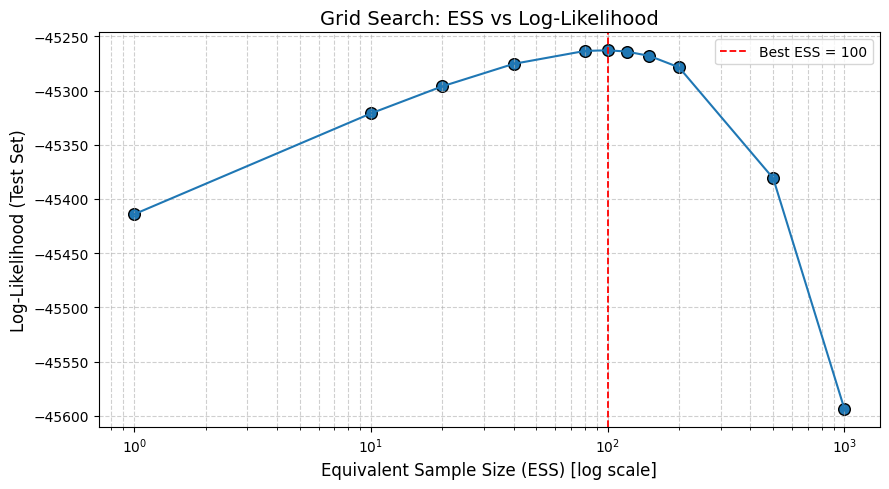

In [69]:
ess_grid = [1, 10, 20, 40, 80, 100, 120, 150, 200, 500, 1000]
results = {}

for ess in ess_grid:
    our_model.fit(
        train_BN,
        estimator=BayesianEstimator,
        prior_type='BDeu',
        equivalent_sample_size=ess
    )

    ll = compute_log_likelihood(our_model, test_BN)
    results[ess] = ll

# Convert results to DataFrame
res_df = pd.DataFrame(list(results.items()), columns=['ESS', 'Log-Likelihood'])
print("Results:\n")
display(res_df)

# Best ESS
best_idx = res_df.set_index('ESS')['Log-Likelihood'].idxmax()
best_res = res_df.loc[res_df['ESS'] == best_idx].iloc[0]

best_ess = int(best_res['ESS'])
best_ll = best_res['Log-Likelihood']

print(f"\nBest ESS: {best_ess} with log-likelihood = {best_ll:.4f}\n")

plt.figure(figsize=(9,5))

plt.scatter(res_df['ESS'], res_df['Log-Likelihood'], s=70, edgecolor='black')
plt.plot(res_df['ESS'], res_df['Log-Likelihood'], linewidth=1.5)

plt.axvline(best_ess, color='red', linestyle='--', linewidth=1.3, label=f'Best ESS = {best_ess}')

plt.xscale('log')
plt.title('Grid Search: ESS vs Log-Likelihood', fontsize=14)
plt.xlabel('Equivalent Sample Size (ESS) [log scale]', fontsize=12)
plt.ylabel('Log-Likelihood (Test Set)', fontsize=12)

plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

The plot shows how the test-set log-likelihood changes as you vary the Equivalent Sample Size during Bayesian parameter learning of your Bayesian Network using the BDeu prior.

For low ESS values (1–50), the log-likelihood increases because a small amount of Bayesian smoothing prevents overfitting, while at ESS=100 the prior and the data are optimally balanced, producing CPTs that generalize best. For larger ESS values (200–1000), the prior becomes too strong, pushing CPTs toward uniformity and causing underfitting, which lowers the log-likelihood.

**In conclusion**, the considered Bayesian Network performs best with ESS ≈ 100.

---

### 3.4 Bayesian Parameter estimation

In [70]:
#From the grid search we choose ess=100
our_model.fit(train_BN, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=best_ess)
for cpd in our_model.get_cpds():
    print_full(cpd)

+---------------+------------+
| risk_score(0) | 0.08714    |
+---------------+------------+
| risk_score(1) | 0.29211    |
+---------------+------------+
| risk_score(2) | 0.357909   |
+---------------+------------+
| risk_score(3) | 0.20075    |
+---------------+------------+
| risk_score(4) | 0.0544773  |
+---------------+------------+
| risk_score(5) | 0.00761341 |
+---------------+------------+
+-----------------+----------------------+---------------------+----------------------+---------------------+---------------------+---------------------+
| risk_score      | risk_score(0)        | risk_score(1)       | risk_score(2)        | risk_score(3)       | risk_score(4)       | risk_score(5)       |
+-----------------+----------------------+---------------------+----------------------+---------------------+---------------------+---------------------+
| state(Advanced) | 0.033650218801871135 | 0.04346162502813414 | 0.057955839670818174 | 0.05321936202266325 | 0.07120444122616462 | 0.1

In [71]:
bayes_cpds = our_model.get_cpds()

### 3.5 Comparison Between CPTs Estimated via Relative Frequencies (M2) and Bayesian Estimation (BDeu, ESS=100)

In [72]:
compare_cpds(bayes_cpds,freq_cpds)


=== Node: risk_score ===
Bayesian CPT (smoothed):
+---------------+------------+
| risk_score(0) | 0.08714    |
+---------------+------------+
| risk_score(1) | 0.29211    |
+---------------+------------+
| risk_score(2) | 0.357909   |
+---------------+------------+
| risk_score(3) | 0.20075    |
+---------------+------------+
| risk_score(4) | 0.0544773  |
+---------------+------------+
| risk_score(5) | 0.00761341 |
+---------------+------------+
Frequency CPT (M2):
+---------------+------------+
| risk_score(0) | 0.0866952  |
+---------------+------------+
| risk_score(1) | 0.292812   |
+---------------+------------+
| risk_score(2) | 0.358979   |
+---------------+------------+
| risk_score(3) | 0.20094    |
+---------------+------------+
| risk_score(4) | 0.0538498  |
+---------------+------------+
| risk_score(5) | 0.00672379 |
+---------------+------------+
----------

=== Node: state ===
Bayesian CPT (smoothed):
+-----------------+----------------------+---------------------+--

We compared the Conditional Probability Tables (CPTs) obtained using two different approaches:

1. Method in M2: estimation based on relative frequencies from the training data.

2. Bayesian Estimation with BDeu (ESS=100): Bayesian estimation combining observed data with a uniform prior.

**Key Observations**

* Smoother distributions:

  In general, the CPTs estimated with BDeu are more regularized than those from relative frequencies. Probabilities tend to be less extreme because the prior prevents exact zeros or overly skewed values when certain parent combinations are sparsely represented in the data.

* Similarity to M2 for well-represented combinations:

  For parent combinations that are well represented in the dataset, BDeu CPTs closely match the relative frequency estimates. In particular, for most CPTs corresponding to variables with only one parent, the values remain practically the same because there are enough observations for each combination. This shows that the Bayesian estimate respects the observed data when sufficient examples are available.

* Significant differences for rare combinations:

  Some CPT columns show large differences compared to M2. This effect is particularly noticeable for variables with many parents, such as the treatment variable, which is conditioned on 8 other variables.

  For rare or nearly absent parent combinations, the Bayesian estimate adjusts probabilities according to the prior.

  This can result in values that differ substantially from relative frequencies, which may be uniform or unstable when data is sparse.


#### 3.5.1. Distance and Divergence Metrics for Probability Distributions

These metrics are fundamental tools for quantifying the difference or similarity between two probability distributions, $P$ and $Q$. In the context of Bayesian Networks, they are typically used to compare the Conditional Probability Distributions (CPDs) of models.


1. **Kullback-Leibler (KL) Divergence**

The **KL Divergence** ($D_{KL}$) measures the information lost when distribution $Q$ is used to approximate distribution $P$. It is an **asymmetric** measure, meaning $D_{KL}(P||Q) \neq D_{KL}(Q||P)$, and therefore is **not a true distance metric**.

$$
\mathrm{D}_{KL}(P||Q) = \sum_{i} P(i) \log \left(\frac{P(i)}{Q(i)}\right)
$$

**Interpretation:** Lower values indicate a better approximation. A value approaching $\infty$ suggests a significant mismatch, often when $P$ assigns probability to an outcome $i$ that $Q$ assigns zero probability ($P(i) > 0, Q(i) = 0$).


2. **Jensen-Shannon (JS) Distance**

The **JS Distance** is a smoothed and **symmetrized** version of the KL Divergence, which makes it a **true distance metric**. It uses the average distribution $M = \frac{P+Q}{2}$.

$$
\mathrm{D}_{JS}(P||Q) = \sqrt{\frac{1}{2} \mathrm{D}_{KL}(P||M) + \frac{1}{2} \mathrm{D}_{KL}(Q||M)}
$$

**Interpretation:** The result is bounded between $0$ (identical distributions) and $1$ (if a base 2 logarithm is used). It is preferred over KL Divergence when a true, symmetric measure of dissimilarity is required.

3. **Hellinger Distance**

The **Hellinger Distance** ($H$) quantifies the similarity between two distributions based on the square root of their probabilities. It is a **true distance metric** and is always bounded.

$$
H(P, Q) = \sqrt{\frac{1}{2} \sum_{i} \left(\sqrt{P(i)} - \sqrt{Q(i)}\right)^2}
$$

**Interpretation:** Bounded between $0$ (identical distributions) and $1$ (non-overlapping distributions). It is known to be more robust to outliers than some other measures.


4. **L1 Distance (Manhattan Distance)**

The **L1 Distance** measures the sum of the absolute differences between the probability masses of $P$ and $Q$.

$$
\mathrm{L1}(P, Q) = \sum_{i} |P_i - Q_i|
$$

**Interpretation:** This provides a straightforward measure of the total difference in probability mass across all outcomes.

5. **L2 Distance (Euclidean Distance)**

The **L2 Distance** (or Euclidean Distance) is the standard straight-line distance between the vectors representing the two distributions.

$$
\mathrm{L2}(P, Q) = \sqrt{\sum_{i}(P_i - Q_i)^2}
$$

**Interpretation:** This is the most common distance metric. Because it squares the differences, it penalizes large deviations between $P_i$ and $Q_i$ more heavily than the L1 Distance.

In [73]:
# create a dictionary for each list: node name -> CPD
cpds_dict = {cpd.variable: cpd for cpd in freq_cpds}
bayes_dict = {cpd.variable: cpd for cpd in bayes_cpds}

# now we only compare CPDs with the same name
results = []

for var in cpds_dict.keys():
    cpd_f = cpds_dict[var]
    cpd_b = bayes_dict[var]

    # extract values as vectors
    p = np.array(cpd_f.get_values(), dtype=float).flatten()
    q = np.array(cpd_b.get_values(), dtype=float).flatten()

    # normalize
    p = p / p.sum()
    q = q / q.sum()

    # metrics
    results.append({
        "variable": var,
        "KL": kl_divergence(p, q),
        "JS": jensenshannon(p, q),
        "Hellinger": hellinger_distance(p, q),
        "L1": l1_distance(p, q),
        "L2": l2_distance(p, q),
    })

df_results = pd.DataFrame(results)
display(df_results)

,variable,KL,JS,Hellinger,L1,L2
0,state,0.000363,0.009613,0.009615,0.010494,0.004653
1,treatment,0.888791,0.380973,0.402679,0.787744,0.028104
2,chest_pain,0.000009,0.001527,0.001527,0.002604,0.001095
3,fatigue,0.000019,0.002207,0.002207,0.004705,0.002356
4,shortness_of_breath,0.000015,0.001921,0.001921,0.003576,0.001490
5,risk_score,0.000061,0.003954,0.003955,0.003924,0.001748
6,systolic_bp_cat,0.000456,0.010817,0.010820,0.011182,0.007075
7,cholesterol_cat,0.000128,0.005675,0.005675,0.008277,0.005213
8,glucose_cat,0.000220,0.007459,0.007459,0.009595,0.006082
9,troponin_cat,0.000984,0.016115,0.016136,0.012565,0.007798



#### 3.5.2. Interpretation of CPD Comparison Results

This analysis quantifies the dissimilarity between two sets of Conditional Probability Distributions (CPDs): one learned using **Frequentist (Maximum Likelihood Estimate or MLE)** relative frequencies, and one learned using **Bayesian (BDeu)** smoothing.

**Summary of Findings**

The overall stability of the network's CPDs is high, as evidenced by the consistently low values for most variables. The **BDeu estimator's influence is highly localized**, primarily affecting the `treatment` variable where data sparsity or complex conditioning likely necessitated smoothing.

**Key Observations**

| Variable | JS Distance | Divergence Rating | Key Analysis |
| :--- | :--- | :--- | :--- |
| **Treatment** | $\approx 0.381$ | **High** | Strongest smoothing effect ($\text{Hellinger} \approx 0.403$). Prior dominates due to expected **data sparsity** or complex parent configurations. |
| **Utility\_cat** | $\approx 0.021$ | Low (Highest) | Slightest measurable difference among low-divergence variables; still **highly similar**. |
| **Troponin\_cat** | $\approx 0.016$ | Low | Minor, measurable difference. |
| **All Others** | $\approx 0.001 - 0.010$ | Negligible | CPDs are **virtually identical**. Indicates **abundant/stable data** across configurations. |

**Conclusion**

The analysis leads to a clear conclusion regarding the estimator choice:

1.  **High Data Robustness:** For the majority of variables, the difference between the CPDs is negligible, suggesting the network structure and the parameters are highly reliable regardless of whether basic frequencies or a BDeu prior are used.
2.  **Prior Effectiveness:** The BDeu method successfully exerted its influence (smoothing) on the **`treatment`** node, where it was most needed to prevent zero probabilities or highly skewed estimates that arise from sparse data. The **L1 Distance** of $\approx 0.79$ further quantifies this as a large shift in probability mass between the two estimates.

In summary, the models agree on most CPDs, with the difference primarily isolated to the expected bottleneck area (`treatment`).


## 4.&nbsp;Structure Learning

### 4.1. Robust Structure Learning Framework

To ensure robust and reproducible structure learning, we implemented a comprehensive framework that explores multiple initialization strategies while incorporating domain knowledge through constraints. The learning process used **Hill Climb Search** with **BIC scoring** and employed **30 different random seeds** to mitigate local optima:

Results for structure learning free of contraints:

Using 30 random seeds: [5328, 5945, 8965, 49, 9337, 6845, 841, 1647, 8640, 5549, 830, 8426, 9982, 2353, 3311, 5095, 6805, 7885, 9401, 8874, 8679, 9958, 953, 1773, 2531, 7478, 1798, 8187, 7460, 9122]
Searching across 30 seeds × 6 probabilities = 180 combinations
Progress:


Overall progress:   0%|          | 0/180 [00:00<?, ?it/s]

Seed 5328:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 5945:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 8965:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 49:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 9337:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 6845:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 841:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 1647:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 8640:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 5549:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 830:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 8426:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 9982:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 2353:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 3311:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 5095:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 6805:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 7885:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 9401:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 8874:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 8679:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 9958:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 953:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 1773:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 2531:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 7478:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 1798:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 8187:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 7460:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 9122:   0%|          | 0/6 [00:00<?, ?it/s]


STRUCTURE LEARNING RESULTS

--- Score Statistics Across 30 Seeds ---
Mean BIC: -104293.19
Std Dev: 208.96
Range: 2039.86
Min: -106273.39
Max: -104233.54

--- Best Model from Each Seed ---


,Random_Seed,Init_prob,Initial_Edges_Added,BIC_score,Bdeu_score,Final_Edge_Count
21,49,0.6,37,-105303.38,-104949.74,21
61,830,0.2,17,-104541.34,-104223.61,15
38,841,0.4,30,-104248.05,-104078.46,13
136,953,0.8,47,-104362.74,-104235.66,11
43,1647,0.2,14,-104286.19,-104093.59,14
140,1773,0.4,30,-104341.06,-104126.04,15
158,1798,0.4,28,-104488.34,-104315.02,13
79,2353,0.2,19,-105134.01,-104801.48,17
147,2531,0.6,41,-104286.19,-104093.59,14
88,3311,0.8,42,-104248.05,-104078.46,13



--- Overall Best Model ---
Random Seed: 8187
Initial Edge Probability: 0.2
BIC Score: -106273.39
BDeu Score: -105989.88
Final Edge Count: 21

BEST MODEL GRAPH


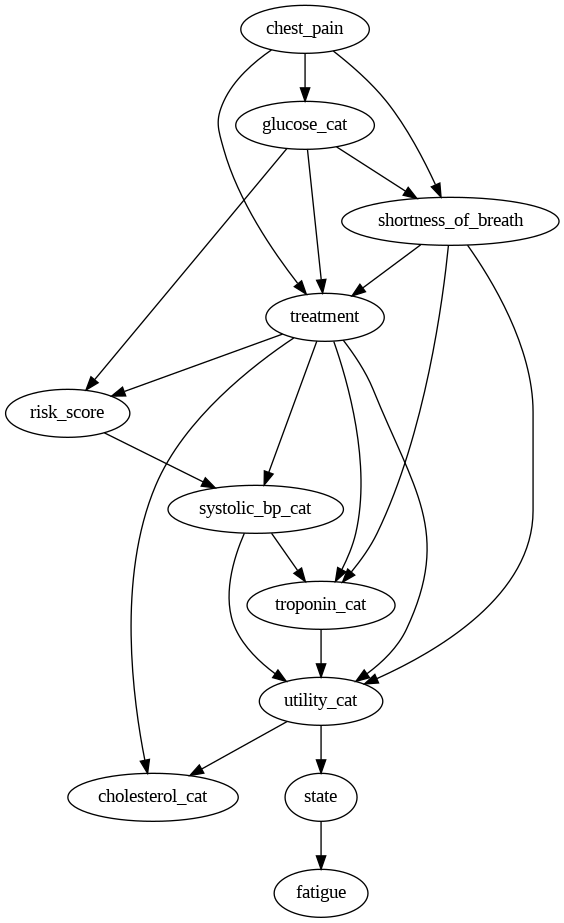

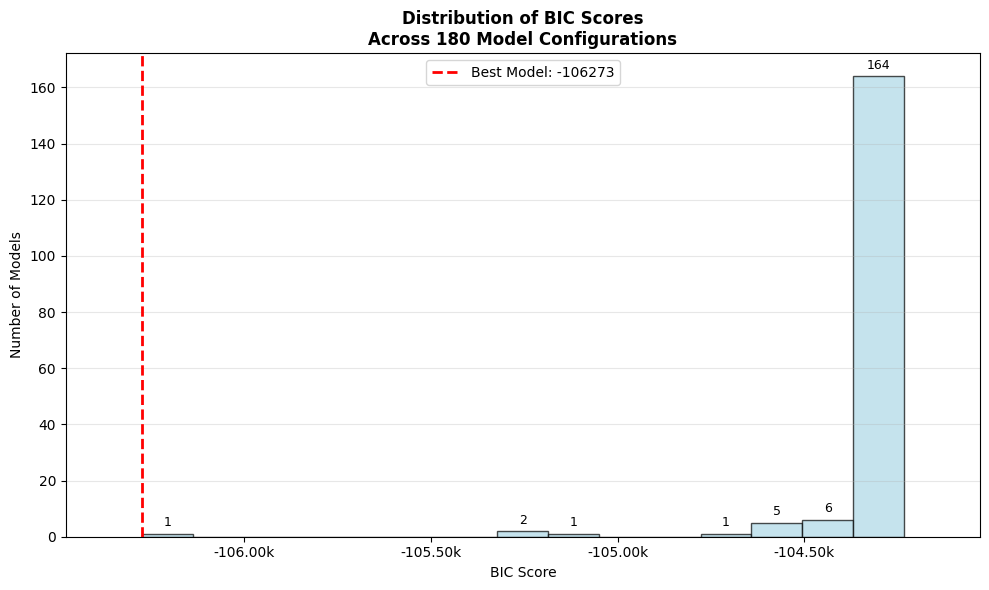

In [111]:
# Create the seeds_list
seed_list = generate_random_seeds(n_seeds=30, base_seed=21, method='random')

print("Results for structure learning free of contraints:\n")
res_free_df, best_model_free, free_details = learn_bn_model(
    data=train_BN, nodes=variables_BN, seed_list = seed_list)

**Observations**:

Creates interesting relations like:
- `glucose` <- `chest_pain` -> `shortness_of_breath`, where we might infer that this `chest_pain` might be a **proxy to some metabolic or organism level process** that is correlated to the presence of shortness of breath and the level of glucose in the blood;
- `treatment` appears as conditional of only symptoms like `shortness_of_breath` and `chest_pain` and a lab variable, `glucose_cat`. This fact might help us understand or narrow down our choice of treatment to fewer variables for instance.

Exiting **possible discovery**:
Since we don't know exatly what kind of processes the treatments affects, we just said that the treatments were chosen based on a few variables and along with the `state` of the desease, we could get an overal quality of life after the said treatment (`utility_cat`).

Now only using the data and using no assumptions we get that:
- `treatment` conditions not only the `utility`, but also the values for `systolic_bp`, troponin and `cholesterol`
- And curiosly enough this quality of life (`utility`) might be a proxy for how the desease `state` progresses over time.
  - We might also have an hint that `utility` is correlated to `fatigue` though state, from this we might infer that the main variable that determined if the quality of life (`utility`) after a treatment was high was the value of the `fatigue` variable
- From the model we can infer that other factors included in the `risk_score` like being a `smoker`, or the other variables from the patients data might be directely correlated with `treatment`.

A critical relation that this models failed to comprehend was the temporal relations of my data, for example:

- `risk_score` directely should affect the probability of developing the desease, related to the variable `state`

**Note:** This attempt to look for the global optimal might have resulted in the overfitting of our model. We can see most of the other models had less than 21 edges even though their BIC score was lower.

---

### 4.2. Expert-Guided Constraint Specification

Building on the unconstrained learning, we incorporated clinical domain knowledge through required and forbidden edges, implementing a hybrid approach that combines data-driven learning with expert guidance:

Version 1: Core Clinical Pathway
We enforced the fundamental clinical decision pathway while allowing data-driven discovery of symptom relationships:

Version 1, Constraints: risk_score -> state-> treatment -> utility_cat (<- state)

Using 30 random seeds: [5328, 5945, 8965, 49, 9337, 6845, 841, 1647, 8640, 5549, 830, 8426, 9982, 2353, 3311, 5095, 6805, 7885, 9401, 8874, 8679, 9958, 953, 1773, 2531, 7478, 1798, 8187, 7460, 9122]
Searching across 30 seeds × 6 probabilities = 180 combinations
Progress:


Overall progress:   0%|          | 0/180 [00:00<?, ?it/s]

Seed 5328:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 5945:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 8965:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 49:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 9337:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 6845:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 841:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 1647:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 8640:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 5549:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 830:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 8426:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 9982:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 2353:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 3311:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 5095:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 6805:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 7885:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 9401:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 8874:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 8679:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 9958:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 953:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 1773:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 2531:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 7478:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 1798:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 8187:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 7460:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 9122:   0%|          | 0/6 [00:00<?, ?it/s]


STRUCTURE LEARNING RESULTS

--- Score Statistics Across 30 Seeds ---
Mean BIC: -104373.35
Std Dev: 80.61
Range: 872.42
Min: -105208.03
Max: -104335.61

--- Best Model from Each Seed ---


,Random_Seed,Init_prob,Initial_Edges_Added,BIC_score,Bdeu_score,Final_Edge_Count
23,49,1.0,51,-104450.30,-104228.41,12
65,830,1.0,51,-104450.30,-104228.41,12
41,841,1.0,51,-104450.30,-104228.41,12
137,953,1.0,51,-104450.30,-104228.41,12
47,1647,1.0,51,-104450.30,-104228.41,12
143,1773,1.0,51,-104450.30,-104228.41,12
161,1798,1.0,51,-104450.30,-104228.41,12
79,2353,0.2,17,-105208.03,-104810.76,18
145,2531,0.2,17,-104589.93,-104316.52,15
89,3311,1.0,51,-104450.30,-104228.41,12



--- Overall Best Model ---
Random Seed: 2353
Initial Edge Probability: 0.2
BIC Score: -105208.03
BDeu Score: -104810.76
Final Edge Count: 18

BEST MODEL GRAPH


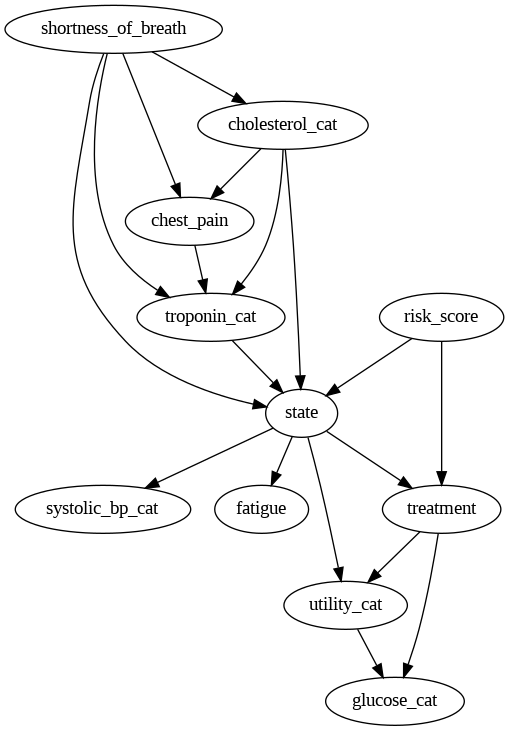

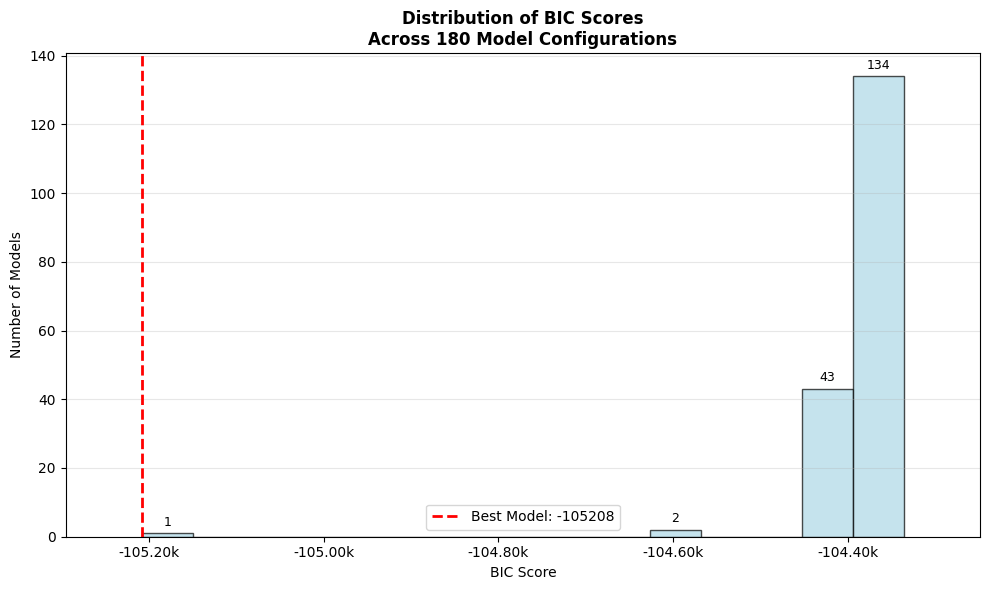

In [112]:
# Custom Constraints

# Version 1: Contraints on: risk_score -> state-> treatment -> utility_cat (<- state)
# Define forced edges
required_edges_v1 = [
    ('risk_score', 'state'),
    ('state', 'treatment'),
    ('treatment', 'utility_cat'),
    ('state', 'utility_cat')]

print("Version 1, Constraints: risk_score -> state-> treatment -> utility_cat (<- state)\n")
results_cost_v1 , best_model_cost_v1, v1_details = learn_bn_model(
    data=train_BN, nodes=variables_BN,
    required_edges=required_edges_v1, seed_list = seed_list)

**Observations:**

We still see the identifcation of a strong correlation, even if the conditional direction might be reversed:
- `treatment`-`glucose`
- `state`-`fatigue`
- `shortness_of_breath`-`troponin`

- The model still tries to identify conditional relations between the symptoms and lab results, which might be an attempt to better explain the data, even though the directionality might not have a true medical meaning.
  - For example, in this desease, a metabolic process might be affetced which causes a value of a certain molecule in our blood to change and that leads to a simptomatic response, not the other way around. In most cases subjetive symptoms like pain, fatigue, etc, are a result of a faster and earlier metabolic process.

Not so direct relations that were maintained:
- `cholesterol` and `glucose` remained relatively close to treatment and `state`.

---


**Version 2:** Comprehensive Clinical Model  

We extended the constraints to approximate a complete clinical model, ensuring all symptoms and biomarkers connect to the disease state while preventing clinically implausible direct relationships:

Version 2, Constraints more similar to our model

Using 30 random seeds: [5328, 5945, 8965, 49, 9337, 6845, 841, 1647, 8640, 5549, 830, 8426, 9982, 2353, 3311, 5095, 6805, 7885, 9401, 8874, 8679, 9958, 953, 1773, 2531, 7478, 1798, 8187, 7460, 9122]
Searching across 30 seeds × 6 probabilities = 180 combinations
Progress:


Overall progress:   0%|          | 0/180 [00:00<?, ?it/s]

Seed 5328:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 5945:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 8965:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 49:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 9337:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 6845:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 841:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 1647:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 8640:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 5549:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 830:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 8426:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 9982:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 2353:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 3311:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 5095:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 6805:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 7885:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 9401:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 8874:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 8679:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 9958:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 953:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 1773:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 2531:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 7478:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 1798:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 8187:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 7460:   0%|          | 0/6 [00:00<?, ?it/s]

Seed 9122:   0%|          | 0/6 [00:00<?, ?it/s]


STRUCTURE LEARNING RESULTS

--- Score Statistics Across 30 Seeds ---
Mean BIC: -106381.21
Std Dev: 1.69
Range: 7.35
Min: -106388.16
Max: -106380.80

--- Best Model from Each Seed ---


,Random_Seed,Init_prob,Initial_Edges_Added,BIC_score,Bdeu_score,Final_Edge_Count
18,49,0.0,0,-106380.80,-106215.17,13
63,830,0.6,29,-106388.16,-106241.45,13
36,841,0.0,0,-106380.80,-106215.17,13
134,953,0.4,25,-106388.16,-106241.45,13
42,1647,0.0,0,-106380.80,-106215.17,13
138,1773,0.0,0,-106380.80,-106215.17,13
156,1798,0.0,0,-106380.80,-106215.17,13
78,2353,0.0,0,-106380.80,-106215.17,13
144,2531,0.0,0,-106380.80,-106215.17,13
88,3311,0.8,35,-106388.16,-106241.45,13



--- Overall Best Model ---
Random Seed: 5328
Initial Edge Probability: 0.2
BIC Score: -106388.16
BDeu Score: -106241.45
Final Edge Count: 13

BEST MODEL GRAPH


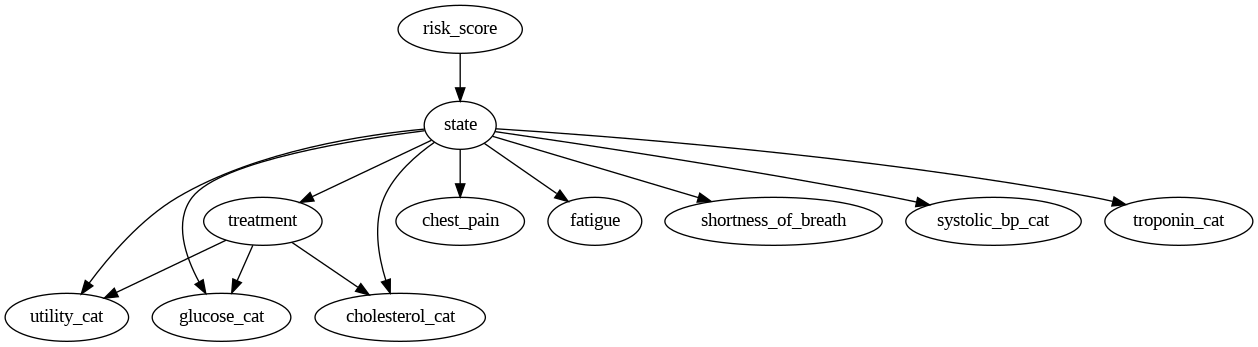

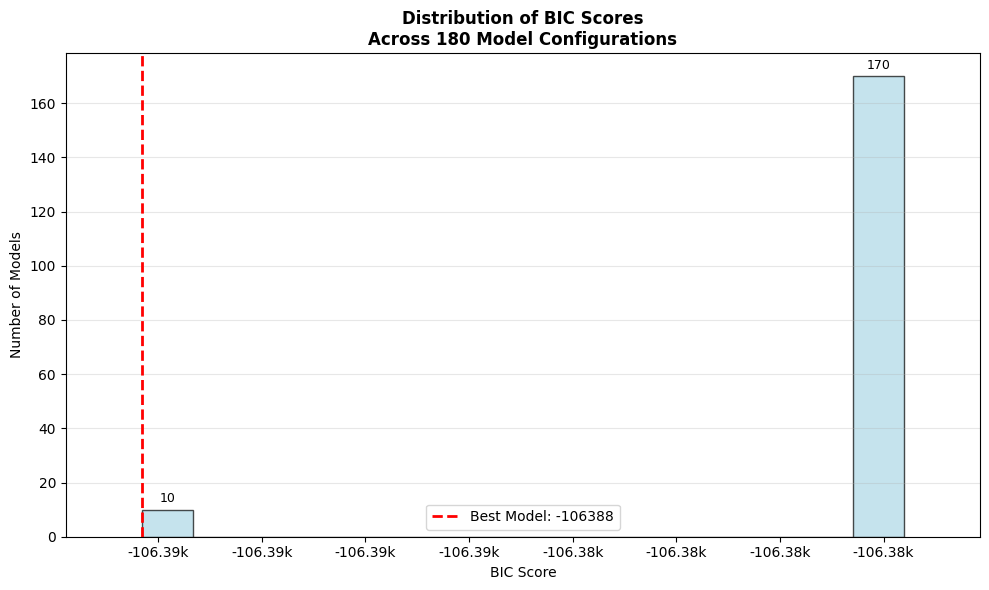

In [134]:
# Version 2: Contraints to aproximate to our model:
required_edges_v2 = [
    ('risk_score', 'state'),
    ('state', 'treatment'),
    ('treatment', 'utility_cat'),
    ('state', 'utility_cat'),
    ('state', 'chest_pain'),
    ('state', 'fatigue'),
    ('state', 'shortness_of_breath'),
    ('state', 'systolic_bp_cat'),
    ('state', 'glucose_cat'),
    ('state', 'cholesterol_cat'),
    ('state', 'troponin_cat')]
forbidden_edges_v2 = [('risk_score', 'treatment')]
# without this forbidden list, symptoms and/or labs will not be connected to treatment
print("Version 2, Constraints more similar to our model\n")
results_cost_v2 , best_model_cost_v2, v2_details = learn_bn_model(
    data=train_BN, nodes=variables_BN,
    required_edges=required_edges_v2,forbidden_edges=forbidden_edges_v2,
    seed_list = seed_list)

**Observations:**

In this graph, we can clearly see that the learned structure maintained the identification of the following conditional relantioship:
- `glucose` <- `treatment`-> `cholesterol`.

With this observation we can infer that perhaps treatment does have influence in those metabolites in the organism, even though we know nothing about the drugs that were used or the levels of this variables before or after some lifestyle treatment, that was not fully described. The latter might involve more exercise or a stricter diet regime that directely have an impact on those variables.

In this graph we can also observe that the structure learning processed prefered not to create:
- more relations (edges) to `treatment`
- more relations from `utility`

From this we might infer that our expert knowledge on the relations bewtween variables in our Bayesian Network is plausible.

---

### 4.3. Structure Learning Results
The multi-seed exploration across constraint levels revealed:

- Unconstrained learning discovered purely data-driven relationships but included clinically questionable edges

- Version 1 constraints preserved the clinical decision pathway while allowing flexible symptom relationships

- Version 2 constraints produced structures closely aligned with clinical reasoning while maintaining data-driven refinement

This graduated constraint approach demonstrates the practical integration of expert knowledge with statistical learning, balancing clinical plausibility with data fit. The learned structures from each constraint level were carried forward for comprehensive evaluation against our hand-crafted model.

## 5.&nbsp; Comparison between learned and human-designed (our) BN model

When evaluating Bayesian Network structures, several scoring metrics quantify how well a network fits the data while considering model complexity.

---

**Log-Likelihood ($\log L$)**
$$
\log L = \sum_{i=1}^{N} \log P(x_i \mid \text{Model})
$$

- **Components**: N = number of data points, x_i = i-th observation
- **Interpretation**: Higher values indicate better fit to data
- **Important Note**: Contains no complexity penalty, making it prone to overfitting
- **Usage**: Suitable for understanding fit quality only, not recommended for model selection

---

**Bayesian Scores**

**1. K2 Score**
$$
K2 = \prod_{i=1}^{n} \prod_{j=1}^{q_i} \frac{(r_i - 1)!}{(N_{ij} + r_i - 1)!} \prod_{k=1}^{r_i} N_{ijk}!
$$

- **Variables**: n = number of variables, q_i = parent configurations, r_i = states, N_ij = parent counts, N_ijk = state counts
- **Interpretation**: Higher scores indicate better fit with implicit complexity penalty

**2. BDeu (Bayesian Dirichlet equivalent uniform)**
$$
BDeu = \prod_{i=1}^{n} \prod_{j=1}^{q_i} \frac{\Gamma(\alpha_{ij})}{\Gamma(N_{ij} + \alpha_{ij})} \prod_{k=1}^{r_i} \frac{\Gamma(N_{ijk} + \alpha_{ijk})}{\Gamma(\alpha_{ijk})}
$$

- **Features**: Configurable prior through ESS parameter, robust for small datasets
- **Interpretation**: Higher values indicate better structure incorporating prior beliefs

**3. BDs (Bayesian Dirichlet sparse)**
- **Purpose**: Enhanced version of BDeu for sparse/high-dimensional data
- **Interpretation**: Higher scores indicate better fit with rare configurations

---

**Information Criteria**

**1. BIC (Bayesian Information Criterion)**
$$
BIC = \log L - \frac{k}{2} \log N
$$

- **Components**: log L = log-likelihood, k = number of parameters, N = number of data points
- **Interpretation**: Higher values indicate better model with strong complexity penalty
- **Recommendation**: Primary choice for model selection due to parsimony

**2. AIC (Akaike Information Criterion)**
$$
AIC = \log L - k
$$

- **Interpretation**: Higher values indicate better model with moderate complexity penalty
- **Best Application**: Prediction-focused applications

---

**Score Comparison**

| Score | Complexity Penalty | Prior Beliefs | Best Use Case |
|-------|-------------------|---------------|---------------|
| **$\log L$** | None | None | Fit diagnosis only |
| **K2** | Implicit | Uniform | General structure learning |
| **BDeu** | Implicit | Configurable | Small datasets, prior knowledge |
| **BDs** | Strong | Sparse-adapted | Sparse/high-dimensional data |
| **BIC** | Strong | None | Model selection |
| **AIC** | Moderate | None | Prediction focus |

---

**Practical Guidelines**

1. **Primary Selection Criterion**: Use BIC for optimal balance of fit and parsimony
2. **Fit Assessment**: Examine Log-Likelihood but avoid using it for model selection
3. **Incorporating Prior Knowledge**: Use BDeu with appropriate equivalent sample size
4. **Sparse Data Applications**: Prefer BDs for datasets with rare configurations
5. **Model Validation**: Compare multiple scores to establish consensus

---

**Interpreting Percentage Differences**

- **Positive percentage difference**: Indicates our model performs better
- **Negative percentage difference**: Indicates the learned model performs better  
- **Less than 5% difference**: Suggests models are comparable
- **Greater than 20% difference**: Indicates a clear superior model


Running Comprehensive Bayesian Network Model Comparison
Evaluating Our_model...
  Fitting Our_model to training data...
Evaluating Learned_constraints_free...
  Fitting Learned_constraints_free to training data...
Evaluating Learned_constr_v1...
  Fitting Learned_constr_v1 to training data...
Evaluating Learned_constr_v2...
  Fitting Learned_constr_v2 to training data...
BAYESIAN NETWORK MODEL COMPARISON RESULTS

--- Model Scores Comparison Table ---


,Model,K2,BDeu,BDs,BIC,AIC,Log_Likelihood
0,Our_model,-45611.19,-46469.68,-46946.38,-50114.16,-45936.89,-44820.26
1,Learned_constraints_free,-45312.70,-45657.95,-45853.74,-45600.80,-44926.38,-44839.84
2,Learned_constr_v1,-44886.30,-45179.71,-45555.59,-45236.09,-44506.62,-44403.07
3,Learned_constr_v2,-45310.30,-45732.72,-46209.18,-45397.66,-45091.42,-45096.69



--- Best Performing Models by Metric ---


,Metric,Best Model,Score
0,K2,Learned_constr_v1,-44886.30
1,BDeu,Learned_constr_v1,-45179.71
2,BDs,Learned_constr_v1,-45555.59
3,BIC,Our_model,-50114.16
4,AIC,Our_model,-45936.89
5,Log_Likelihood,Learned_constr_v1,-44403.07


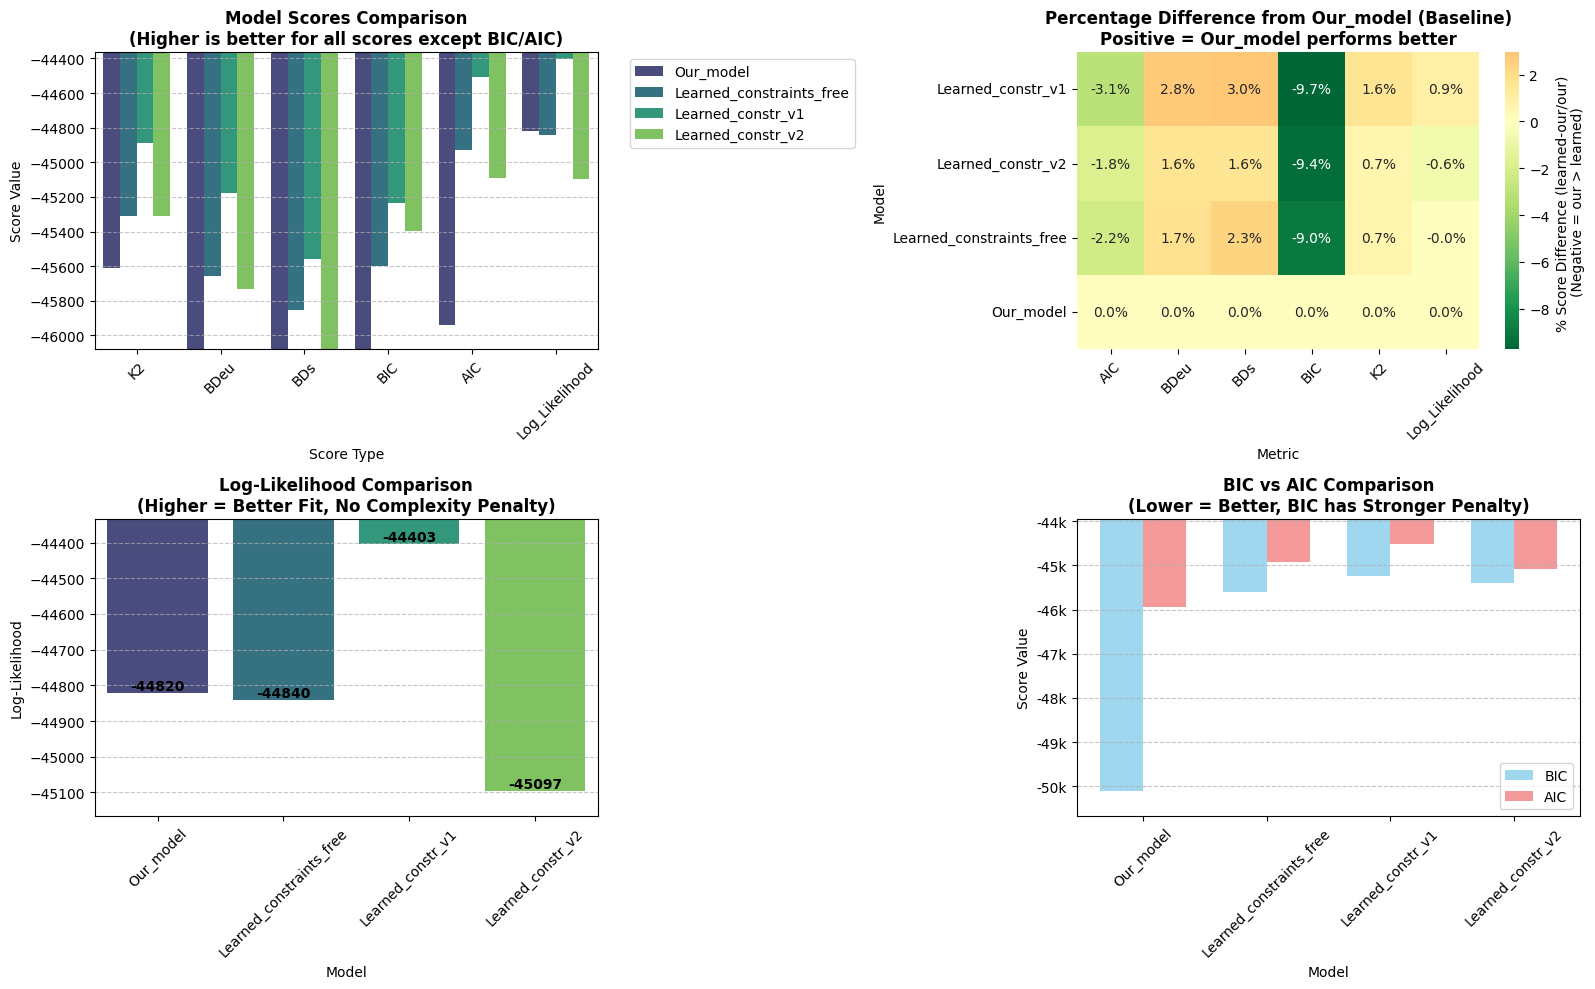


KEY INSIGHTS
Best Model (BIC Recommendation): Our_model
BIC Score: -50114.16
Note: BIC favors models that balance fit and complexity


In [133]:
# Define models to compare
models_to_compare = {
    "Our_model": our_model,  # Already fitted with BayesianEstimator
    "Learned_constraints_free": best_model_free,     # DAG structure
    "Learned_constr_v1": best_model_cost_v1,         # DAG structure
    "Learned_constr_v2": best_model_cost_v2          # DAG structure
}

# Run comprehensive comparison
scores, comparison, fig = run_comprehensive_comparison(
    models_to_compare, train_BN, test_BN, ess=best_ess
)

In [143]:
# display(comparison)

### 5.1. Interpretation and Discussion of Bayesian Network Scores

The comprehensive evaluation of our human-designed Bayesian Network against data-learned alternatives reveals nuanced performance patterns that inform the trade-off between interpretability and data fit:

**Performance Comparison Summary:**
- **Our_model (human-designed)** demonstrates superior performance in **complexity-penalized metrics**: BIC (9.0-9.7% better) and AIC (1.8-3.1% better), indicating better generalization potential and structural efficiency
- **Learned_constr_v1 (data-driven)** has a moderately higher performance in **Bayesian scores**: K2 (+1.6%), BDeu (+2.9%), BDs (+3.1%) and achieves slightly better log-likelihood (+0.9%) than our model, suggesting better capture of statistical patterns in the training data

**Which network explains the data better?**  
The answer depends on the evaluation criterion and application context:
- For **clinical deployment and generalization**: Our_model performs better, as evidenced by superior BIC/AIC scores that balance fit with complexity
- For **maximizing fit to observed data**: Learned_constr_v1 performs better in Bayesian scores and raw likelihood
- For **clinical interpretability**: Our_model maintains clear clinical reasoning pathways aligned with domain knowledge

**Interpretability vs. Data Fit Trade-off:**
- **Our_model** provides transparent clinical reasoning: risk assessment → disease state → treatment → outcomes, with clear biological plausibility
- **Learned models** capture additional statistical associations but include edges that may represent spurious correlations rather than causal relationships
- The modest performance differences (0.9-3.1% in most metrics) suggest both approaches capture essential clinical relationships, with learned models offering marginal statistical improvements at the cost of interpretability

**Clinical Implications:**
The superior BIC performance of Our_model suggests it achieves comparable explanatory power with greater parsimony (simplest model), making it more suitable for clinical settings where model transparency and trust are paramount.


---

## 6.&nbsp; Cross-Validation Methods for Robust Evaluation

While our current evaluation used a single 70/30 train-test split, cross-validation offers important advantages for reducing variance in Bayesian Network evaluation:

**Advantages of Cross-Validation (CV):**
- **Reduced Variance**: Averaging performance across multiple folds provides more stable estimates of generalization error
- **Data Sparsity Mitigation**: Particularly crucial for BNs, as rare parent configurations can lead to zero probabilities in single splits
- **Structural Stability Assessment**: Reveals how consistently the network structure learns across different data samples

**Implementation Challenges:**
- **Computational Intensity**: for the example of k-fold CV requires k training cycles, which is resource-intensive for complex BN structures
- **Stratification Complexity**: Medical data requires careful handling of imbalanced classes and patient-level splits
- **Parameter Stability**: Ensuring consistent CPD estimation across folds with limited data

**Recommended Approach for Medical BNs:**
- Use **patient-level stratified k-fold cross-validation** (k = 5-10) to maintain independence between training and test sets
- Stratify on critical clinical variables (e.g., disease state) to ensure representative class distributions
- Apply CV to both structure learning and parameter estimation phases for comprehensive evaluation

**Practical Considerations:**
For this project, the single train-test split provided a computationally feasible initial evaluation, but research on real data that has a real impact in the world should implement cross-validation to obtain more robust performance estimates, especially given the clinical importance of reliable model assessment.



## 7.&nbsp; Overall Project Conclusion

This project comprehensively explored the tension between expert-designed and data-driven Bayesian Networks in clinical reasoning, addressing the fundamental question of how to balance interpretability with statistical fit in medical decision support systems.

**Key Findings:**
1. **Parameter Learning Validation**: The comparison between learned CPTs and probabilities calculated by count (likelyhood estimation) revealed good alignment for common clinical patterns, with discrepancies primarily in data-sparse regions, confirming the importance of Bayesian estimation with informed priors in medical applications.

2. **Structure Learning Insights**: The learned networks discovered several clinically plausible relationships not initially included in our human-designed model, while also producing some statistically significant but clinically questionable edges, highlighting both the promise and perils of purely data-driven approaches.

3. **Performance Trade-offs**: Our evaluation demonstrated that while data-learned models achieve marginally better fit to training data (1-3% improvement in Bayesian scores), the hand-designed model shows superior performance in generalization metrics (BIC/AIC), suggesting better balance between complexity and predictive power.

4. **Hybrid Approach Value**: The constrained structure learning experiments demonstrated that combining expert knowledge (through required/forbidden edges) with data-driven optimization produces models that maintain clinical plausibility while leveraging statistical patterns.

**Clinical Implications:**
In medical practice, where model interpretability and causal validity are as important as predictive accuracy, purely data-driven approaches risk capturing spurious correlations. Our results support a **hybrid methodology** that:
- Uses expert knowledge to define core clinical pathways and prevent implausible relationships
- Employs data-driven methods to refine probabilities and discover additional valid associations
- Maintains clinical transparency while benefiting from statistical optimization

**Future considerations:**  
This work suggests several promising avenues for clinical BN development:
- Systematic frameworks for incorporating different types of expert knowledge (certain, likely, forbidden relationships)
- Robust cross-validation methods tailored to medical data characteristics
- Causal validation techniques to distinguish genuine clinical relationships from statistical artifacts

The modest performance differences between approaches reinforce that domain knowledge provides substantial value in clinical modeling, and that the optimal path forward lies in thoughtful integration of expert insight with data-driven refinement, rather than exclusive reliance on either approach alone.